In [ ]:
%%capture
import numpy as np
!pip install qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute
from qiskit import BasicAer as Aer
from qiskit.tools.visualization import circuit_drawer, plot_histogram

En este notebook vamos a introducir los componentes básicos usados en el gate model de computación cuántica, que es el modelo hoy en día más explorado tanto en la industria (Alibaba, Baidu, Google, HP, IBM Q, Intel, IonQ, Microsoft, Rigetti Computing, Tencent, etc) como en la academia. La forma de implementar este tipo de computadoras es muy variada y no esta claro quién tendrá la ventaja: chips superconductores, sistemas fotónicos y trampas de iones son los más comunes, cada cual con sus ventajas y desventajas. Vamos a ver algoritmos cuánticos independientemente de la implementación.

Generalmente los algoritmos cuánticos se piensan primero en términos matemáticos y luego se los ajusta al lenguaje de compuertas, que es universal pero para nada sencillo.

Vamos a usar Qiskit en todo el notebook.

# Introducción a Qiskit

[Qiskit](https://www.qiskit.org/) es un paquete que nos permite definir circuitos cuánticos, simular e implementar una colección de algoritmos. Es desarrollado por IBM y permite correr código en sus dispositivos.


Los elementos fundamentales son los registros clásicos y cuánticos, y los circuitos:

In [ ]:
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit

El registro clásico guarda los resultados de las medidas. El circuito cuántico toma compuertas que operan en el registro cuántico. Vamos a necesitar tambien ejecutar el circuito:

In [ ]:
from qiskit import execute

La ejecución puede hacerse en un procesador cuántico o en un simulador clásico. Vamos a usar el simulados, llamado Aer en qiskit. Para usar la computadora cuántica real, es necesario configurar tokens y manejar los límites de tiempo:

In [ ]:
from qiskit import BasicAer as Aer

En este simulador tenemos multiples backends, que eligiremos en función de lo que querramos hacer.

Saquemosle precisión a los outputs de qiskit para no tener información innecesaria:

In [ ]:
import numpy as np
np.set_printoptions(precision=3, suppress=True)

### Backends



Vamos a usar el backend `qasm_simulator`. Este corre el algoritmo cuántico y lo guarda en un registro clásico. 

In [ ]:
backend = Aer.get_backend('qasm_simulator')

Construyamos el circuito más simple sin compuertas, solo con un qubit de entrada y un registro clásico.

In [ ]:
q = QuantumRegister(1)
c = ClassicalRegister(1)
circuit = QuantumCircuit(q, c)
circuit.measure(q[0], c[0])

Ejecutemosle y veamos las estadísticas. Con shots controlo la cantidad de veces que lo ejecuto.

In [ ]:
job = execute(circuit, backend, shots=100)
result = job.result()
result.get_counts(circuit)

{'0': 100}

Los qubits se inicializan en $|0\rangle$, con lo cual no es sorprendente que de 100 ejecuciones hayamos medidos '0' 100 veces. Si lo ejecutacemos en el procesador cuántico, tendríamos cada tanto algún '1' debido al ruido.

Existen por supuesto otros backends para ver otras cosas. A partir de estas medidas es dificil reconstruir el estado cuántico. Si quisieramos conseguir el estado, podriamos usar el backend `statevector_simulator`.

In [ ]:
backend = Aer.get_backend('statevector_simulator')

En este caso no hace falta agregar la medida, a no ser que la querramos usar como parte del algoritmo. Necesitamos para que no devuelva error, introducir al menos un operador identidad (`id`).

In [ ]:
circuit = QuantumCircuit(q, c)
circuit.id(q[0])
job = execute(circuit, backend)
state = job.result().get_statevector(circuit)
print(state)

[1.+0.j 0.+0.j]


Ahora vemos el estado $|0\rangle$ en lugar de estadística de medida. El tipo de medidas que podemos hacer son restrictivas, siempre podemos medira en la base "computacional" de $S_z$. Los estados $|1\rangle$ y $-|1\rangle$ son indistinguibles si solo vemos estadística, pero distinguibles viendo los estados.

### Visualización

Hay 3 maneras principales de visualizar lo que estamos haciendo. En primer lugar, graficar el circuito:

In [ ]:
from qiskit.tools.visualization import circuit_drawer
q = QuantumRegister(1)
c = ClassicalRegister(1)
circuit = QuantumCircuit(q, c)
circuit.measure(q[0], c[0])
circuit_drawer(circuit)

┌─┐
q3_0: ┤M├
      └╥┘
c1: 1/═╩═
       0

Esto nos sirve para chequear que estemos haciendo las cosas bien.

La segunda tiene que ver con la operación en la esfera de Bloch, que es una forma de visualizar estados de 1 qubit en el espacio de Hilbert. Comparemos el estado antes y después de ser rotado con la compuerta Hadamard (ya vamos a hablar que sobre ella):

Initial state


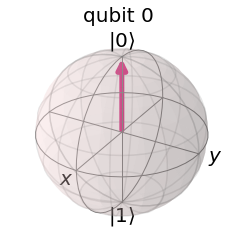

In [ ]:
from qiskit.tools.visualization import plot_bloch_multivector
backend = Aer.get_backend('statevector_simulator')
circuit = QuantumCircuit(q, c)
circuit.id(q[0])
job = execute(circuit, backend)
state = job.result().get_statevector(circuit)
print("Estado incial")
plot_bloch_multivector(state)

Después de aplicar Hadamard:

After a Hadamard gate


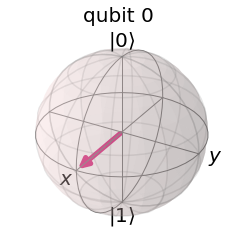

In [ ]:
circuit.h(q[0])
job = execute(circuit, backend)
state = job.result().get_statevector(circuit)
print("Después de aplicar Hadamard")
plot_bloch_multivector(state)

La tercera forma de visualizar tiene que ver con la estadística, y es hacer un histograma de los resultados. Es lo más práctico para debugging y aplicaciones concretas. Volvemos al backend `qasm_simulator`.

Initial state statistics


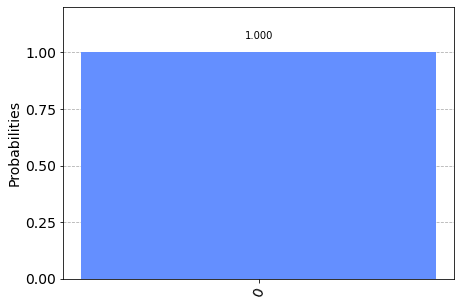

In [ ]:
from qiskit.tools.visualization import plot_histogram
backend = Aer.get_backend('qasm_simulator')
q = QuantumRegister(1)
c = ClassicalRegister(1)
circuit = QuantumCircuit(q, c)
circuit.measure(q[0], c[0])
job = execute(circuit, backend, shots=1000)
print("Estadística del estado inicial")
plot_histogram(job.result().get_counts(circuit))

Statistics if we apply a Hadamard gate


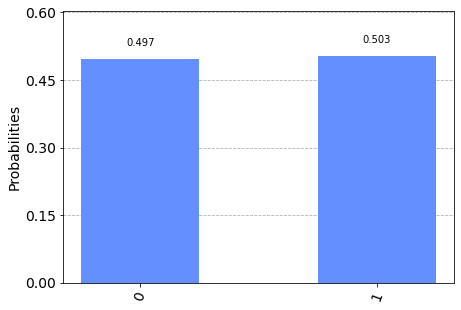

In [ ]:
circuit = QuantumCircuit(q, c)
circuit.h(q[0])
circuit.measure(q[0], c[0])
job = execute(circuit, backend, shots=1000)
print("Estadística después de aplicar Hadamard")
plot_histogram(job.result().get_counts(circuit))

Este simulador no tiene ruido. El hecho de que no sea uniforme tiene que ver con la naturaleza estadística de la medida. Con más muestras, el histograma se hará más parejo. 

El ruido en los sistemas reales es un factor muy considerable y para nada despreciable.

# Compuertas cuánticas



Los circuitos se componen de registros. Por un lado tenemos qubits de registro cuántico, sobre las cuales actúan compuertas, y por el otro registros clásicos sobre los cuales se guardan los resultados de las  medidas. Es un nivel de programación de muy bajo nivel, similar a assembly en computadoras clásicas.

Los registros cuánticos se idexan desde el 0. Nos referimos al qubit 0, qubit 1, qubit 2, etc. Esto no debe confundirse con el estado del qubit, que puede ser $|0\rangle$, $|1\rangle$, o cualquier superposición. 

En computación clásica, se transforman strings de bits en otros strings de bits mediante compuertas lógicas. Cualquier string de bits puede conseguirse con solo 2 compuertas, lo que hace posible la computación universal con operaciones simples compuestas por estas dos compuertas. Es extraordinario y sorprendente que lo mismo sea cierto para computación cuántica:  cualquier operación unitaria puede descomponerse en compuertas elementales. Además, neceistamos solo 3 tipos de compuertas para tener universalidad. Esto es sorprendente porque estamos hablando de transformaciones continuas de amplitudes de probabilidad, no solo elementos discretos. Esto es lo que nos dá un marco teórico para crear algoritmos cuánticos de más alto nivel.

Veamos las compuertas más comunes. No todas son unitarias.

| Gate (Compuerta) |Nombre                | &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Matriz |
|------|--------------------|---------------------------------------------------------------------|
|   X  | Pauli-X ó NOT gate|$\begin{bmatrix}0 & 1\\ 1& 0\end{bmatrix}$|
|   Z  | Pauli-Z  gate      |$\begin{bmatrix}1 & 0\\ 0& -1\end{bmatrix}$|
|  H   | Hadamard gate      |$\frac{1}{\sqrt{2}}\begin{bmatrix}1 & 1\\ 1& -1\end{bmatrix}$|
| Rx($\theta$)| Rotación alrededor de X|$\begin{bmatrix}\cos(\theta/2) & -i \sin(\theta/2)\\ -i \sin(\theta / 2) & \cos(\theta / 2)\end{bmatrix}$|
| Ry($\theta$)| Rotación alrededor de Y|$\begin{bmatrix}\cos(\theta/2) & -\sin(\theta/2)\\ \sin(\theta / 2) & \cos(\theta / 2)\end{bmatrix}$|
| CNOT, CX | Controlled-NOT | $\begin{bmatrix}1 & 0 & 0 &0\\ 0 & 1 & 0 &0\\ 0 & 0 & 0 &1\\ 0 & 0 & 1 &0\end{bmatrix}$|

Algo interesante de la tabla es que hay muchas (en ppio infinitas) operaciones de 1 qubit. La rotación por ejemplo se parametriza con un parámetro continuo. Esto contrasta fuertemente con circuitos clásicos, donde la única operación no trivial sobre un bit es la negación NOT.

La compuerta CNOT es la única compuerta de 2 qubits en esta lista. Tiene un rol especial: nos da la interacción de 2 qubits necesaria para generar entrelazamiento. Veamos el circuito para crear  $|\phi^+\rangle = \frac{1}{\sqrt{2}}(|00\rangle+|11\rangle)$.  Vamos a tener 2 registros de qubits y 2 registros clásicos para las medidas. Definamos y ploteemos el circuito:


In [ ]:
q = QuantumRegister(2)
c = ClassicalRegister(2)
circuit = QuantumCircuit(q, c)
circuit.h(q[0])
circuit.cx(q[0], q[1])
circuit_drawer(circuit)

┌───┐     
q0_0: ┤ H ├──■──
      └───┘┌─┴─┐
q0_1: ─────┤ X ├
           └───┘
c0: 2/══════════

Todos los registros cuánticos se inicializan en $|0\rangle$ y crear el estado deseado es **parte** del circuito. La preparación de estados arbitrarios es casi siempre el objetivo del algoritmo. Algunos estados son más sencillos de preparar que otros. El circuito de arriba tiene solo 2 gates, por lo cual es bastante sencillo.

Veamos que pasa en este circuito: La Hadamard gate prepara el estado en una superposición homogenea $\frac{1}{\sqrt{2}}(|0\rangle+|1\rangle)$ sobre el qubit 0. Este qubit controla una compuerta X sobre el qubit 1. Como se encuentra en superposición, va a aplicar X también en superposición. Sobre la primer parte  ($|0\rangle$) no se va a aplicar X, y sobre la segunda parte ($|1\rangle$) sí. Entonces el estado final es $\frac{1}{\sqrt{2}}(|00\rangle+|11\rangle)$, que es un [estado máximamente entrelazado de 2 qubits](https://en.wikipedia.org/wiki/Bell_state).

Una computadora clásica procesa sobre registros de 64 bits y consigue hacer computación universal con ello. Cualquier cálculo complejo puede descomponerse en operaciones elementales sobre 64 bits, tanto secuenciales como en paralelo. La pregunta entonces es por que nos preocupamos de tener muchos qubits en las computadoras cuánticas. ¿No nos alcanza con 64 qubits?

En entrelazamiento es la forma más simple de entender porque necesitamos tantos qubits. El entrelazamiento es un recurso fundamental en computación cuántica y queremos aprovecharlo. Si tenemos 64 qubits y queremos entrelazar uno adicional a estos 64 registros, tendríamos que borrar un qubit del registro, destruyendo superposición y eventualmente entrelazamiento en el chip. La única forma de aprovechar las correlaciones dadas por el entrelazamiento es planteando el sistema completo en el procesador cuántico durante toda la duración del cálculo.

Es por este motivo que la computadora cuántica es bien vista para resolver problemas dificiles de separar en cálculos elementares pequeños, como el problema del [traveling salesman](https://en.wikipedia.org/wiki/Travelling_salesman_problem) (hallar forma óptima de conectar ciudades minimizando la distancia).

Para terminar el circuito, le podríamos agregar una medida a cada qubit:


In [ ]:
circuit.measure(q, c)
circuit_drawer(circuit)

┌───┐     ┌─┐   
q0_0: ┤ H ├──■──┤M├───
      └───┘┌─┴─┐└╥┘┌─┐
q0_1: ─────┤ X ├─╫─┤M├
           └───┘ ║ └╥┘
c0: 2/═══════════╩══╩═
                 0  1

Y graficamos la estadística

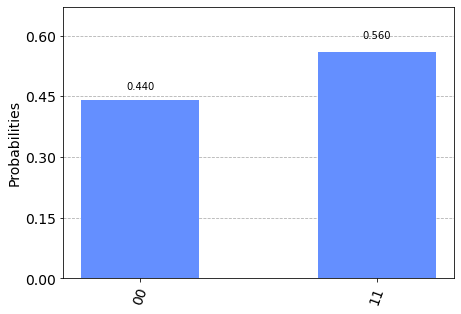

In [ ]:
backend = Aer.get_backend('qasm_simulator')
job = execute(circuit, backend, shots=100)
plot_histogram(job.result().get_counts(circuit))

# Algoritmos fundamentales

Dos de los algoritmos cuánticos más famosos e imporantes son quantum Fourier transform y quantum phase estimation. Sirven de base para muchos otros algoritmos, como por ejemplo inversión de matrices. 

Estos algoritmos son protocolos coherentes. Es decir, input y output son estados cuánticos de los cuales no tenemos información clásica. El protocolo real necesita medidas y post selección. Hacer tomografía de estados al final para reconstruir clasicamente la información del estado cuántico es muy costoso a nivel recursos, lo que eliminaría las ventajas cuánticas.

Un problema adicional que tienen estos algoritmos es que suelen necesitar una gran cantidad de compuertas de qubits de alta calidad. 

## Quantum Fourier Transform


El algoritmo de quantum Fourier transform sirve para hacer una transformación de Fourier discreta sobre las amplitudes de la función de onda. Una explicación bastante completa puede verse en los [tutoriales de Qiskit](https://github.com/Qiskit/qiskit-tutorials/blob/master/community/algorithms/shor_algorithm.ipynb).

La transformación de Fourier discreta clásica actúa sobre un vector $\vec{x}=\begin{bmatrix}x_0\\ \vdots\\ x_{N-1}\end{bmatrix}$  y lo mapea al vector $\vec{y}=\begin{bmatrix}y_0\\ \vdots\\ y_{N-1}\end{bmatrix}$, donde  $y_k = \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}x_je^{ \boldsymbol{2\pi i} \frac{jk}{N}}$.

La quantum Fourier transform actúa sobre la variante del vector encodeada en amplitud, es decir el estado  $|x\rangle=\sum_{i=0}^{N-1} x_i |i \rangle$, y lo mapea al estado cuántico  $|y\rangle=\sum_{k=0}^{N-1} y_k |k \rangle$, donde $y_k = \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}x_je^{\boldsymbol{2\pi i} \frac{jk}{N}}$. Lo único que se transforma, en la práctica, son las amplitudes.

Para derivar el circuito para n qubits, consideremos la transformación sobre el estado  $| x \rangle = | x_1...x_n \rangle$ donde $x_1$ es el bit más significante. Vamos a escribir un número $y$ en su descomposición binaria fraccionaria, es decir  $j = 0.j_1...j_n = \sum_{k=1}^n j_k/2^k$. Por ejemplo $0.8125_d = 0.1101_b = \sum_{k=1}^4 j_k/2^k = 1/2 + 1/4 + 0/8 + 1/16$, donde $d$ es "decimal" y $b$ "binario. La acción de la transformación unitaria $U$ que describe esta transformación puede expandirse como

\begin{aligned}
U |x \rangle = U |x_1 x_2 \cdots x_n \rangle& = \frac{1}{\sqrt{N}} \sum_{k=0}^{2^n-1} e^{\boldsymbol{2\pi i} xk / 2^n} |k \rangle \\
& = \frac{1}{\sqrt{N}} \sum_{k_1=0}^{1}\ldots\sum_{k_n=0}^{1} e^{\boldsymbol{2\pi i} x\left(\sum_{l=1}^n k_l2^{-l}\right) } \vert k_1 ... k_n \rangle \\
& = \frac{1}{\sqrt{N}} \sum_{k_1=0}^{1}\ldots\sum_{k_n=0}^{1} \bigotimes_{l=1}^n e^{\boldsymbol{2\pi i} x k_l2^{-l}} | k_1 ... k_n \rangle \\
& = \frac{1}{\sqrt{N}} \bigotimes_{l=1}^n \sum_{k_l=0}^{1}  e^{\boldsymbol{2\pi i} x k_l2^{-l}} | k_1 ... k_n \rangle \\
& = \frac{1}{\sqrt{N}} \bigotimes_{l=1}^n  \left(|0\rangle + e^{\boldsymbol{2\pi i} x 2^{-l} } |1\rangle \right) \\
& = \frac{1}{\sqrt{N}} \left(|0\rangle + e^{\boldsymbol{2\pi i} 0.x_n} |1\rangle\right) \otimes...\otimes  \left(\vert0\rangle + e^{\boldsymbol{2\pi i} 0.x_1.x_2...x_{n-1}.x_n} |1\rangle\right) 
\end{aligned}

Esta forma de QFT es más útil para construir el circuito, ya que solo el último qubit depende de los valores de todos los otros qubits de input. Los qubits restantes dependen cada vez menos de los qubits de entrada. Esta estructura simple permite descomponer la unitaria en Hadamards y rotaciones.



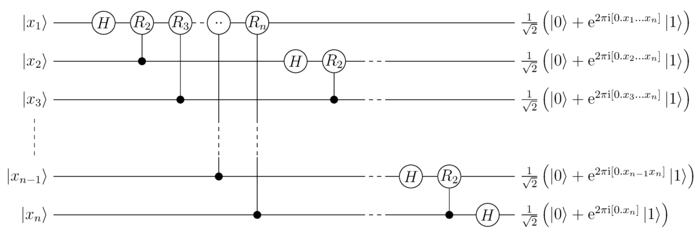

 Para 3 qubits podemos definir el circuito de la siguiente manera:

In [ ]:
π = np.pi
q = QuantumRegister(3, 'q')
c = ClassicalRegister(1, 'c')
qft = QuantumCircuit(q, c)
qft.h(q[0])
qft.cp(π/2, q[1], q[0])
qft.h(q[1])
qft.cp(π/4, q[2], q[0])
qft.cp(π/2, q[2], q[1])
qft.h(q[2])

In [ ]:
from qiskit.tools.visualization import circuit_drawer
circuit_drawer(qft)

┌───┐┌────────┐     ┌────────┐               
q_0: ┤ H ├┤ P(π/2) ├─────┤ P(π/4) ├───────────────
     └───┘└───┬────┘┌───┐└───┬────┘┌────────┐     
q_1: ─────────■─────┤ H ├────┼─────┤ P(π/2) ├─────
                    └───┘    │     └───┬────┘┌───┐
q_2: ────────────────────────■─────────■─────┤ H ├
                                             └───┘
c: 1/═════════════════════════════════════════════

La complejidad escalea como $O(N^2)$

## Quantum Phase Estimation

El objetivo del algoritmo de estimación de fase es, dada una unitaria $U$ y un autovector $|\psi\rangle$ de $U$, estimar $\theta$ en $U|\psi \rangle =e^{2 i \pi \theta}|\psi \rangle$. Como $U$ es unitaria, todos sus autovalores tienen valor absoluto 1. Por convención, $\theta$ se toman
 entre $[0,1]$ y se llama *fase* de $U$ asociada a $|\psi\rangle$.

El autovector de $|\psi\rangle$ se guarda en un conjunto de registros cuánticos. Un conjunto adicional de $n$ qubits forman el registro de ancilla. Al final del proceso, esta ancilla debe contenter una aproximación de la [fracción binaria](https://www.electronics-tutorials.ws/binary/binary-fractions.html) asociada a  $\theta$, con $n$ bits de precisión. Un componente crucial de en este proceso es el de unitarias controladas $C-U^{2^k}$, que asumimos posible en el protocolo de phase estimation.

En primer lugar, preparamos la superposición en la ancilla de registro a través de compuertas de Hadamard $H$. Estos qubits van a actuar de controles para los operadores unitarios en diferentes tiempos. Nuestro objetivo es crear una superposición de $U$ a medida que se aplica con diferentes duraciones. Como los autovalores están siempre en el círculo unidad, la componentes evolucionan de forma distinta en superposición. Dado el registro de ancilla, tenemos una superposición de todos los posibles pasos temporales entre $0$ y $2^{n-1}$, y vamos a terminar con una superposición de todas las posibles evoluciones encodeadas en la representación binaria de los autovalores. Al final del procedimiento tenemos el estado

\begin{aligned}
& \frac {1}{2^{\frac {n}{2}}} (|0\rangle+{e^{2 i \pi \theta \cdot 2^{n-1}}}|1\rangle ) \otimes \cdots (|0\rangle+{e^{2 i \pi \theta \cdot 2^{1}}}|1\rangle ) \otimes (|0\rangle+{e^{2i \pi \theta \cdot 2^{0}}}|1\rangle ) = \\
&\frac {1}{2^{\frac {n}{2}}}\sum _{k=0}^{2^{n}-1}e^{2 i \pi \theta k}|k\rangle
\end{aligned}

en la ancilla. 

Finalmente aplicamos la transformación de Fourier inversa en la ancilla. Midiento en la base computacional, obtenemos la fase en el registro de la ancilla:

\begin{align}
\frac {1}{2^{\frac {n}{2}}}\sum _{k=0}^{2^{n}-1}e^{2i \pi \theta k}|k\rangle \otimes | \psi \rangle \xrightarrow{\mathcal{QFT}_n^{-1}} | \tilde{\theta} \rangle \otimes | \psi \rangle
\end{align}

donde  $\tilde{\theta}$ es la aproximación de $n$ bits a la representación fraccional binaria de $\theta$.

Tomemos un ejemplo de juguete, la matriz unitaria de  $2\times 2$  $\begin{bmatrix}e^{0} & 0 \\0 & e^{i \pi}\end{bmatrix}=\begin{bmatrix}1 & 0 \\0 & -1\end{bmatrix}$, que tiene autovectores $|0\rangle$ y $|1\rangle$, y fases  $\theta_0=0$ y $\theta_1=\frac{1}{2}$. La compuerta  $C-U^{2^k}$ es una controlled-Z para $k=0$ y es la identidad para $k\geq 1$.

Empezamos con $|\psi\rangle=|0\rangle$ en el registro principal, preparamos la superposición en la ancilla:


In [ ]:
q = QuantumRegister(3, 'q')
c = ClassicalRegister(2, 'c')

qpe = QuantumCircuit(q, c)
qpe.h(q[0])
qpe.h(q[1])

Ahora aplicamos la operación controlada:

In [ ]:
# U0 controlada
qpe.cz(q[1], q[2])
# U1 controlada
# nada: identidad

Aplicamos la transformación e Fourier inversa para escribir la fase en la ancilla de registro

In [ ]:
π = np.pi
qpe.swap(q[0], q[1])
qpe.h(q[1])
qpe.cu1(-π / 2, q[0], q[1])
qpe.h(q[0])
qpe.swap(q[0], q[1])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: The QuantumCircuit.cu1 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cp method instead, which acts identically.
  after removing the cwd from sys.path.


Veamos el resultado en los dos primeros registros

In [ ]:
qpe.measure(q[0], c[0])
qpe.measure(q[1], c[1])

In [ ]:
circuit_drawer(qpe)

┌───┐                       ┌───┐   ┌─┐   
q_0: ┤ H ├─X───────X───────■─────┤ H ├─X─┤M├───
     ├───┤ │ ┌───┐ │ ┌───┐ │-π/2 └───┘ │ └╥┘┌─┐
q_1: ┤ H ├─X─┤ H ├─X─┤ H ├─■───────────X──╫─┤M├
     └───┘   └───┘   └───┘                ║ └╥┘
q_2: ─────────────────────────────────────╫──╫─
                                          ║  ║ 
c: 2/═════════════════════════════════════╩══╩═
                                          0  1

Testeemos el circuito:

In [ ]:
backend = Aer.get_backend('qasm_simulator')
job = execute(qpe, backend, shots=1000)
result = job.result()
result.get_counts(qpe)

{'00': 520, '10': 480}

Como esperabamos, tenemos $|2 \cdot \theta_0\rangle=|2\cdot 0\rangle=|00\rangle$.

Para el autovector $|1\rangle$ tenemos

In [ ]:
qpe = QuantumCircuit(q, c)
qpe.h(q[0])
qpe.h(q[1])
qpe.x(q[2]) # crea |1> en el registro principal
qpe.cz(q[1], q[2])

qpe.swap(q[0], q[1])
qpe.h(q[1])
qpe.cu1(-π / 2, q[0], q[1])
qpe.h(q[0])
qpe.swap(q[0], q[1])

qpe.measure(q[0], c[0])
qpe.measure(q[1], c[1])

In [ ]:
backend = Aer.get_backend('qasm_simulator')
job = execute(qpe, backend, shots=1000)
result = job.result()
result.get_counts(qpe)

{'10': 1000}

El resultado debe ser $|10\rangle$. Ya que, $10 \rightarrow 1\cdot 2^{-1} + 0 \cdot 2^0=\frac{1}{2}=\theta_1$